# Benchmark an implementation of DCA against the real deal

**Authorship:**
Adam Klie, *01/22/2022*
***
**Description:**
Notebook to collect data for performing the autoencoder exercise outlined [here](https://www.notion.so/Autoencoder-Workshop-73d10091ac014f8c966a503e02759b11).
***
**Notes:**
 - You will need a kernel with [Scanpy](https://scanpy-tutorials.readthedocs.io/) installed. Follow the below instructions if you would like to build a kernel yourself, or simply use the following environment: `/cellar/users/aklie/opt/miniconda3/envs/single_cell_py` (see the autoencoder exercise instructions for setting up kernel using another user's environment).
 
```bash
conda create -n single_cell_py python=3.6 seaborn scikit-learn statsmodels numba
conda activate single_cell_py
conda install -c conda-forge python-igraph louvain leidenalg
conda install -c conda-forge python-igraph louvain leidenalg
pip install scanpy
pip install ipython ipykernel
python -m ipykernel install --user --name single_cell_py --display-name "Python 3 single_cell"
```
***

# Set-up

In [2]:
# The classics
import numpy as np
import pandas as pd

# Single cell analysis
import scanpy as sc
sc.settings.verbosity = 2
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# DCA
from dca.api import dca

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2


/cellar/users/aklie/opt/miniconda3/envs/single_cell_py_dev/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


# Raw counts

In [66]:
# Original raw counts
pbmc3k = sc.read_h5ad("data/pbmc3k_raw.h5ad")
geneids = np.loadtxt("data/pbmc3k_geneids.txt", dtype=str)
pbmc3k = pbmc3k[:, geneids]
pbmc3k.X.A

array([[0., 0., 0., ..., 1., 0., 4.],
       [0., 0., 0., ..., 1., 0., 8.],
       [1., 0., 0., ..., 2., 0., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 3.]], dtype=float32)

In [67]:
# Save a copy for dca
pbmc3k_dca = pbmc3k.copy()

normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)


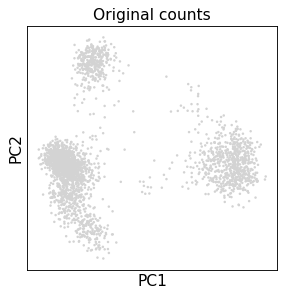

In [68]:
# Visualize PCA
sc.pp.normalize_per_cell(pbmc3k)
sc.pp.log1p(pbmc3k)
sc.pp.pca(pbmc3k)
sc.pl.pca_scatter(pbmc3k, size=20, title='Original counts')

# Implemted DCA

In [74]:
# My implementation of DCA counts
dca_counts = np.load("data/pbmc3k_dca.npy")
pbmc3k_ae = sc.AnnData(X=dca_counts, obs=pbmc3k.obs, var=pbmc3k.var)
pbmc3k_ae.X

array([[4.05900704e-04, 4.77141693e-05, 7.52337452e-04, ...,
        2.48537064e+00, 1.11948336e-02, 1.18127832e+01],
       [9.99999975e-06, 9.99999975e-06, 1.72451034e-01, ...,
        2.13495655e+01, 9.99999975e-06, 3.24837402e+02],
       [1.86268255e-04, 9.99999975e-06, 1.25216239e-03, ...,
        3.05452967e+00, 1.13767395e-02, 2.96447430e+01],
       ...,
       [1.99740264e-03, 9.99999975e-06, 8.50617047e-03, ...,
        2.29634666e+00, 7.19227828e-03, 5.72160244e+00],
       [6.44731998e-01, 9.30274764e-05, 1.67286098e-02, ...,
        6.39897346e-01, 1.68139003e-02, 5.36588240e+00],
       [2.48318259e-03, 1.78929677e-05, 6.57081837e-03, ...,
        7.51003444e-01, 1.62145272e-02, 1.33250132e+01]], dtype=float32)

computing PCA
    with n_comps=50
    finished (0:00:00)


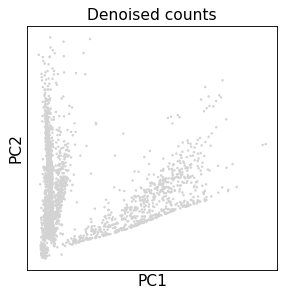

In [75]:
sc.pp.log1p(pbmc3k_ae)
sc.pp.pca(pbmc3k_ae)
sc.pl.pca_scatter(pbmc3k_ae, size=20, title='Denoised counts')

# Original DCA implementation

In [76]:
# Using the scanpy DCA implementaiton
sc.pp.filter_genes(pbmc3k_dca, min_counts=1)
dca(pbmc3k_dca, threads=4)
pbmc3k_dca.X

AssertionError: Make sure that the dataset (adata.X) contains unnormalized count data.

computing PCA
    with n_comps=50
    finished (0:00:00)


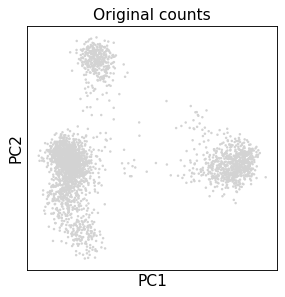

In [77]:
sc.pp.log1p(pbmc3k)
sc.pp.pca(pbmc3k)
sc.pl.pca_scatter(pbmc3k, size=20, title='Original counts')

# References
1. [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs)